In [41]:
import torch
import numpy as np
from torch import nn, optim
from torchvision import datasets
import torchvision.transforms as T
try:
  import torchmetrics
  from torchmetrics import F1Score
except:
  ! pip install torchmetrics
  import torchmetrics
  from torchmetrics import F1Score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision.io import read_image
import os
from PIL import Image

In [42]:
from pathlib import Path
import shutil

ds_path = Path('/content/drive/MyDrive/Data/animal_expression')
if not os.path.exists(ds_path):
  ds_path.mkdir(exist_ok = True, parents = True)
  full_path = Path('/content/drive/MyDrive/Data/animal_expression/animal_expression.zip')
  if not os.path.isfile(full_path):
    ds_zipped = Path('/content/drive/MyDrive/Data/animal_expression.zip')
    shutil.move(ds_zipped, ds_path)

In [43]:
! ls /content/drive/MyDrive/Data/animal_expression

 Angry	 animal_expression.zip	 happy	'Master Folder'   Other   Sad


In [44]:
# ! unzip '/content/drive/MyDrive/Data/animal_expression/animal_expression.zip' -d '/content/drive/MyDrive/Data/animal_expression/'

In [45]:
train_path = '/content/drive/MyDrive/Data/animal_expression/Master Folder/train'
test_path = '/content/drive/MyDrive/Data/animal_expression/Master Folder/test'

In [46]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

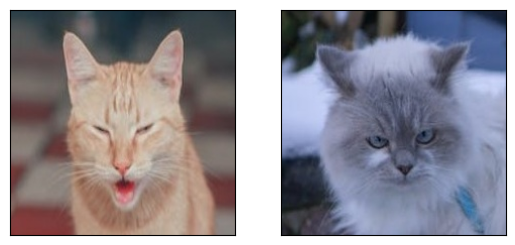

In [47]:
ang1 = read_image(str(train_path+'/Angry/02.jpg'))
ang2 = read_image(str(train_path+'/Angry/03.jpg'))
show([ang1, ang2])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


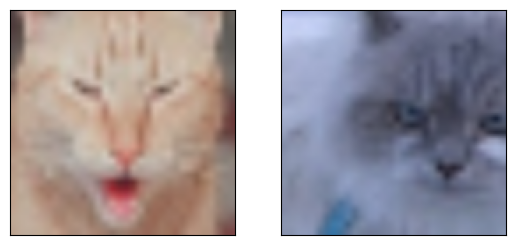

In [48]:
transforms = torch.nn.Sequential(
    T.RandomResizedCrop(size=(32, 32)),
    T.RandomHorizontalFlip(p=0.3),
    T.Resize(128),
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

ang1 = ang1.to(device)
ang2 = ang2.to(device)

transformed_ang1 = transforms(ang1)
transformed_ang2 = transforms(ang2)
show([transformed_ang1, transformed_ang2])

In [49]:
transformed_ang1.shape

torch.Size([3, 128, 128])

In [50]:
transformed_ang1.shape[-1]

128

In [51]:
torch.Tensor([2,3]).shape

torch.Size([2])

In [52]:
resized_imgs = [T.Resize(size=size)(ang1) for size in (30, 50, 100, ang1.shape[-1])]

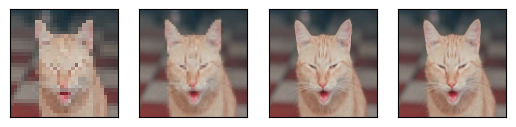

In [53]:
show([*resized_imgs])

In [54]:
resize_cropper = T.RandomResizedCrop(size=(32, 32))
resized_crops = [resize_cropper(ang2) for _ in range(4)]

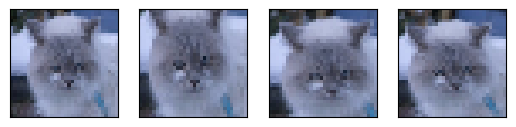

In [55]:
show([*resized_crops])

In [87]:
train_transforms = T.Compose([
    T.ToTensor(),
    T.RandomResizedCrop(size=(64, 64)),
    T.RandomHorizontalFlip(p=0.1),
    T.Resize(128),
])

test_transforms = T.Compose([
    T.ToTensor(),
    T.Resize(128),
])

In [88]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_index = {"Angry": 0, "happy": 1, "Other": 2, "Sad": 3}
        self.image_paths = self._load_image_paths()

    def _load_image_paths(self):
        image_paths = []
        for class_name in os.listdir(self.root_dir):
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                class_idx = self.class_to_index[class_name]
                for filename in os.listdir(class_dir):
                    image_paths.append((os.path.join(class_dir, filename), class_idx))
        return image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path, label = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label_tensor = torch.zeros(4)
        label_tensor[label] = 1

        return image, label_tensor


In [89]:
train_dataset = CustomDataset(root_dir=train_path, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [90]:
test_dataset = CustomDataset(root_dir=test_path, transform=train_transforms)
test_loader = DataLoader(test_dataset, shuffle=False)

In [91]:
num_of_pixels = len(train_dataset) * 128 * 128

total_sum = 0
for batch in train_loader: total_sum += batch[0].sum()
mean = total_sum / num_of_pixels

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [92]:
total_sum = 0
for batch in train_loader: total_sum += batch[0].sum()
mean = total_sum / num_of_pixels
mean

tensor(1.3437)

In [93]:
sum_of_squared_error = 0
for batch in train_loader: sum_of_squared_error += ((batch[0] - mean).pow(2)).sum()
std = torch.sqrt(sum_of_squared_error/num_of_pixels)
std

tensor(1.6132)

In [94]:
mean, std

(tensor(1.3437), tensor(1.6132))

In [95]:
normalize = T.Compose([
    T.Normalize(mean, std)
])

In [96]:
normalized_ang_1 = normalize(next(iter(train_loader))[0][3])

In [97]:
normalized_ang_1

tensor([[[-0.7150, -0.7143, -0.7130,  ..., -0.2370, -0.2383, -0.2390],
         [-0.7159, -0.7149, -0.7128,  ..., -0.2371, -0.2382, -0.2387],
         [-0.7178, -0.7160, -0.7126,  ..., -0.2372, -0.2378, -0.2382],
         ...,
         [-0.7343, -0.7378, -0.7449,  ..., -0.3537, -0.3600, -0.3632],
         [-0.7380, -0.7407, -0.7462,  ..., -0.3414, -0.3488, -0.3524],
         [-0.7398, -0.7422, -0.7469,  ..., -0.3353, -0.3431, -0.3470]],

        [[-0.7472, -0.7463, -0.7447,  ..., -0.2542, -0.2538, -0.2536],
         [-0.7467, -0.7459, -0.7442,  ..., -0.2544, -0.2533, -0.2527],
         [-0.7459, -0.7450, -0.7433,  ..., -0.2547, -0.2522, -0.2509],
         ...,
         [-0.7602, -0.7620, -0.7657,  ..., -0.4045, -0.4214, -0.4298],
         [-0.7625, -0.7641, -0.7673,  ..., -0.3836, -0.4044, -0.4148],
         [-0.7636, -0.7651, -0.7681,  ..., -0.3731, -0.3959, -0.4073]],

        [[-0.7551, -0.7562, -0.7585,  ..., -0.2582, -0.2551, -0.2536],
         [-0.7551, -0.7561, -0.7581,  ..., -0

In [98]:
normalized_ang_1.mean()

tensor(-0.6401)

In [99]:
class_names = list(train_dataset.class_to_index.keys())

In [100]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [101]:
device

device(type='cuda', index=0)

In [102]:
train_image_batch, train_label_batch = next(iter(train_loader))

In [103]:
train_image_batch[0], class_names[train_label_batch[0].argmax()]

(tensor([[[0.9055, 0.9056, 0.9058,  ..., 0.5628, 0.5650, 0.5661],
          [0.8998, 0.8997, 0.8994,  ..., 0.5122, 0.5127, 0.5129],
          [0.8884, 0.8878, 0.8865,  ..., 0.4110, 0.4080, 0.4066],
          ...,
          [0.8891, 0.8874, 0.8841,  ..., 0.8715, 0.8744, 0.8758],
          [0.8848, 0.8830, 0.8794,  ..., 0.8681, 0.8686, 0.8689],
          [0.8827, 0.8808, 0.8771,  ..., 0.8663, 0.8658, 0.8655]],
 
         [[0.8418, 0.8419, 0.8420,  ..., 0.4877, 0.4907, 0.4923],
          [0.8334, 0.8332, 0.8329,  ..., 0.4420, 0.4431, 0.4437],
          [0.8166, 0.8160, 0.8147,  ..., 0.3506, 0.3479, 0.3466],
          ...,
          [0.8616, 0.8604, 0.8581,  ..., 0.7156, 0.7207, 0.7233],
          [0.8547, 0.8531, 0.8498,  ..., 0.7154, 0.7194, 0.7214],
          [0.8513, 0.8495, 0.8457,  ..., 0.7154, 0.7187, 0.7204]],
 
         [[0.7127, 0.7128, 0.7130,  ..., 0.3603, 0.3655, 0.3681],
          [0.7042, 0.7041, 0.7038,  ..., 0.3253, 0.3290, 0.3309],
          [0.6873, 0.6867, 0.6854,  ...,

In [104]:
train_image_batch[0].shape, train_label_batch[0].shape

(torch.Size([3, 128, 128]), torch.Size([4]))

In [105]:
train_dataset[900][1]

tensor([0., 1., 0., 0.])

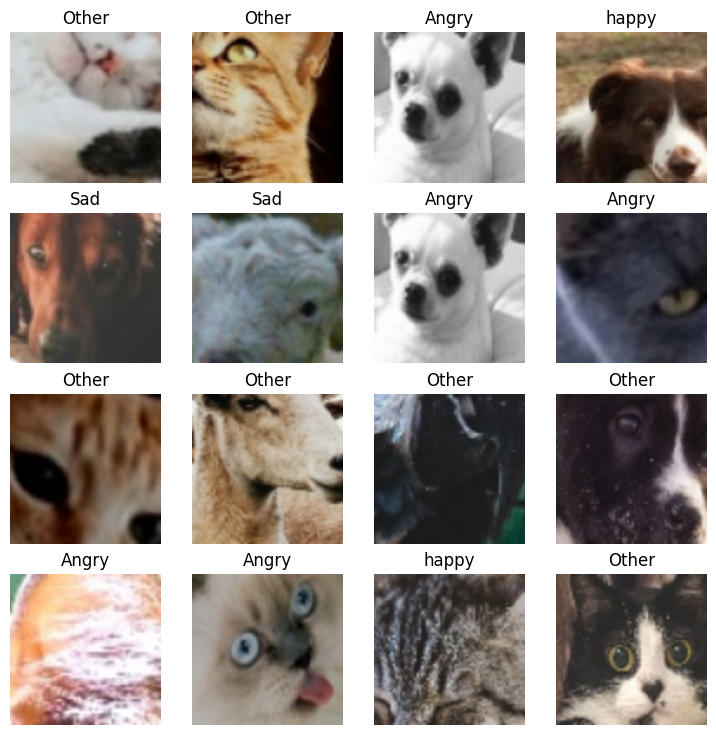

In [106]:
# Show a sample
fig = plt.figure(figsize = (9,9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_image_batch), size=[1]).item()
  img_data, label = train_image_batch[random_idx], train_label_batch[random_idx]
  img = np.transpose(img_data.squeeze(), (1, 2, 0))
  fig.add_subplot(rows, cols, i)
  plt.imshow(img)
  plt.title(class_names[label.argmax()])
  plt.axis("Off");

In [165]:
class BaselineExpressionModelV0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
        T.Normalize(mean, std),
        nn.Conv2d(
            in_channels = input_shape,
            out_channels = hidden_units,
            kernel_size = 3,
            stride = 3,
            padding = 1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels = hidden_units,
            out_channels = hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, 3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 1000,
                  out_features = output_shape)
    )

  def forward(self, X: torch.Tensor) -> torch.Tensor:
    X = self.block_1(X)
    X = self.block_2(X)
    X = self.classifier(X)

    return X

In [166]:
torch.manual_seed(42)
model_0 = BaselineExpressionModelV0(input_shape = 3, hidden_units = 10, output_shape = len(class_names)).to(device)

In [167]:
model_0

BaselineExpressionModelV0(
  (block_1): Sequential(
    (0): Normalize(mean=1.3437020778656006, std=1.6132266521453857)
    (1): Conv2d(3, 10, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1000, out_features=4, bias=True)
  )
)

In [168]:
accuracy_fn = torchmetrics.F1Score(task="multilabel", num_labels=len(class_names)).to(device)

In [169]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr= 1e-1)

In [170]:
train_image_batch[0], train_label_batch[0]

(tensor([[[0.9055, 0.9056, 0.9058,  ..., 0.5628, 0.5650, 0.5661],
          [0.8998, 0.8997, 0.8994,  ..., 0.5122, 0.5127, 0.5129],
          [0.8884, 0.8878, 0.8865,  ..., 0.4110, 0.4080, 0.4066],
          ...,
          [0.8891, 0.8874, 0.8841,  ..., 0.8715, 0.8744, 0.8758],
          [0.8848, 0.8830, 0.8794,  ..., 0.8681, 0.8686, 0.8689],
          [0.8827, 0.8808, 0.8771,  ..., 0.8663, 0.8658, 0.8655]],
 
         [[0.8418, 0.8419, 0.8420,  ..., 0.4877, 0.4907, 0.4923],
          [0.8334, 0.8332, 0.8329,  ..., 0.4420, 0.4431, 0.4437],
          [0.8166, 0.8160, 0.8147,  ..., 0.3506, 0.3479, 0.3466],
          ...,
          [0.8616, 0.8604, 0.8581,  ..., 0.7156, 0.7207, 0.7233],
          [0.8547, 0.8531, 0.8498,  ..., 0.7154, 0.7194, 0.7214],
          [0.8513, 0.8495, 0.8457,  ..., 0.7154, 0.7187, 0.7204]],
 
         [[0.7127, 0.7128, 0.7130,  ..., 0.3603, 0.3655, 0.3681],
          [0.7042, 0.7041, 0.7038,  ..., 0.3253, 0.3290, 0.3309],
          [0.6873, 0.6867, 0.6854,  ...,

In [171]:
y_logits = model_0(train_image_batch[0].unsqueeze(0).to(device))

In [172]:
train_image_batch[0].unsqueeze(0).shape

torch.Size([1, 3, 128, 128])

In [173]:
next(iter(train_loader))[0][0].shape

torch.Size([3, 128, 128])

In [174]:
y_logits

tensor([[ 0.0067, -0.0258,  0.0559,  0.0202]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [175]:
y_pred_probs = torch.softmax(y_logits, dim = 1)

In [176]:
y_pred_probs

tensor([[0.2480, 0.2401, 0.2605, 0.2514]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [177]:
y_pred_probs.sum()

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [178]:
torch.argmax(y_pred_probs)

tensor(2, device='cuda:0')

In [179]:
y_logits

tensor([[ 0.0067, -0.0258,  0.0559,  0.0202]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [180]:
train_label_batch[0]

tensor([0., 0., 0., 1.])

In [181]:
loss_fn(y_pred_probs.squeeze(), train_label_batch[0].to(device))

tensor(1.3849, device='cuda:0', grad_fn=<DivBackward1>)

In [182]:
train_label_batch[0].unsqueeze(dim = 0)

tensor([[0., 0., 0., 1.]])

In [183]:
y_logits.shape

torch.Size([1, 4])

In [184]:
accuracy_fn(y_logits, train_label_batch[0].unsqueeze(dim = 0).to(device))

tensor(0.5000, device='cuda:0')

In [201]:
class Fit:
  def __init__(self, model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, test_dataloader: torch.utils.data.DataLoader, epochs: int, optimizer: torch.optim.Optimizer, accuracy_fn, loss_fn: torch.nn.Module, device: torch.device = device):

    self.model = model
    self.epochs = epochs
    self.train_dataloader = train_dataloader
    self.test_dataloader = test_dataloader
    self.optimizer = optimizer
    self.loss_fn = loss_fn
    self.accuracy_fn = accuracy_fn
    self.device = device

    self.train = self.train__()
    self.test = self.test__()
    self.epoch_count = []
    self.model.to(device)


  def train__(self):
    train_loss, train_acc = 0, 0
    self.total_train_loss = []
    self.total_train_acc = []


    self.model.train()

    for batch, (X, y) in enumerate(self.train_dataloader):
      X, y = X.to(device), y.to(device)
      y_logits = self.model(X)
      y_pred = torch.softmax(y_logits, dim = 1)

      loss = self.loss_fn(y_pred.squeeze(), y)
      train_loss += loss
      train_acc += self.accuracy_fn(y_pred, y).item() * 100

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss /= len(self.train_dataloader)
    self.total_train_loss.append(train_loss)
    train_acc /= len(self.train_dataloader)
    self.total_train_acc.append(train_acc)


    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

  def test__(self):
    test_loss, test_acc = 0,0
    self.total_test_loss = []
    self.total_test_acc = []

    self.model.eval()

    with torch.inference_mode():
      for X, y in self.test_dataloader:
        X, y = X.to(device), y.to(device)

        test_logits = self.model(X)
        test_pred = torch.softmax(test_logits, dim = 1)

        test_loss += self.loss_fn(test_pred.squeeze(), y)
        test_acc += self.accuracy_fn(test_pred, y).item() * 100

        test_loss/= len(self.test_dataloader)
        self.total_test_loss.append(test_loss)
        test_acc/= len(self.test_dataloader)
        self.total_test_acc.append(test_acc)

      print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


  def __call__(self):
    for epoch in tqdm(range(self.epochs)):
      print(f'Epoch: {epoch}\n------------------------')
      self.train
      self.test
      self.epoch_count.append(epoch)

  def plot_train_test_curves(self):
    plt.figure(figsize = (9,9))

    plt.subplot(1, 2, 1)
    plt.plot(self.epoch_count, self.total_train_loss, 'go--', color = 'blue', label = 'Training_loss')
    plt.plot(self.epoch_count, self.total_test_loss, color = 'red', label = 'Test_loss')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(self.epoch_count, self.total_train_acc, 'go--', color = 'blue', label = 'Training_loss')
    plt.plot(self.epoch_count, self.total_test_acc, color = 'red', label = 'Test_loss')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    plt.show()

  def get_model(self):
    return self.model


In [202]:
history = Fit(model = model_0,
              train_dataloader = train_loader,
              test_dataloader = test_loader,
              epochs = 10,
              optimizer = optimizer,
              accuracy_fn = accuracy_fn,
              loss_fn = loss_fn,
              device = device
              )

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train loss: 1.38655 | Train accuracy: 0.00%


RuntimeError: ignored